<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/abr29_Regresion_covidCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,6,6,34
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8


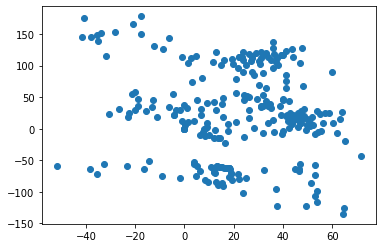

In [57]:

import numpy as np
import matplotlib.pyplot as plt
plt.scatter(Xd['Lat'],Xd['Long'])

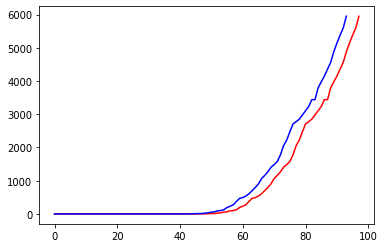

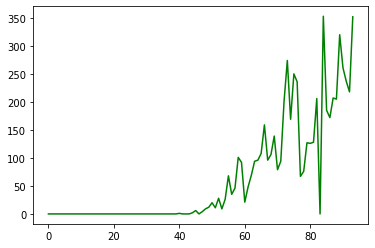

In [58]:
import numpy as np
import matplotlib.pyplot as plt

#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N


ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
w = 3
X,y = covid_win(serie,w=w)
X_d,y_d = covid_win(serie_d,w=w)

plt.plot(serie,'r')
plt.plot(y,'b')
plt.show()
plt.plot(y_d,'g')



# Entrenamiento de regresor para covid 19 - Colombia
# Análisis exploratorio - visualización en 2D PCA
# Validación cruzada y anidada (pocos datos)

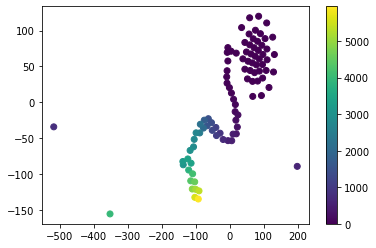

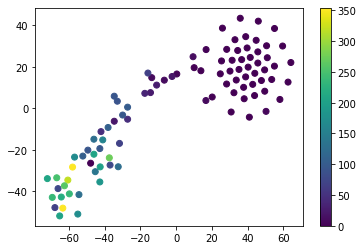

In [59]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

red = TSNE(n_components = 2,perplexity=10)
red_d = TSNE(n_components = 2,perplexity=10)

#red = PCA()
#red_d = PCA()


z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()


plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()


In [60]:
red_d.explained_variance_ratio_

AttributeError: ignored

$$w^* = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top y $$

$$y_n = \phi_n w^*$$


$\lambda$: hyperparameter

$\Phi(x)=\mathcal{N}(x|\mu,\sigma^2)$

$\mu,\sigma$ hyperparameters

$w$: model's parameter

In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
#pocos datos y mucha incertidumbre, validación cruzada anidada

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape)
print(X_test.shape)

In [0]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as msa

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))], #clasificador 
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),
          ('reg', KernelRidge(kernel = 'rbf'))], #clasificador 
         ]        


#parametros a buscar por busqueda por grilla
parameters =[
             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
             },
             {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
              'rep__n_components':[0.5,0.75,0.9]
             },
              ]

label_model = ['NorSC-KRRBF','NorSC-PCA-KRRBF']


In [0]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
best_estimators = Niter*[len(label_model)*[None]]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[len(label_model)*[None]]#mejor metodo por iteracion 
#############################
          

for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) # xtrain 60, xtest 26
      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          best_estimators[j][r] = grid_search.best_estimator_
          best_hyperpar[j][r] = grid_search.best_params_
          
          #guardar acierto
          msev[j,r] = msa(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          print(best_hyperpar)
          print('mse:',msev[j,r])
          
          savedata = {
              'acc':msev,
              'best_models':best_estimators,
              'best_parameters':best_hyperpar,
                } 
          dump(savedata,'covid19_1.joblib')

Por Niter de outter loop tengo valores de los hyperparameters

$$\gamma = [0.01,0.1,10,1000,10000,0.01]$$

$$\gamma = [0.01,0.01,0.01,0.1,1,0.01]$$

$$\gamma^* = moda/mediana(\gamma_i) = 0.01$$

Toma todos los datos los N = 85, entreno sobre todo el conjunto con los parametros encontrados utilizando validación cruzada anidad

$$\theta^*/w^* =f(X|\gamma^*)$$

$$ y_{new} = f(x_{new}|\gamma^*,\theta^*/w^*)$$

In [0]:
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()

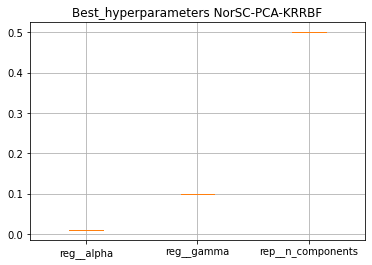

Modes=  [0.01 0.1  0.5 ]
Predicción contagiados covid19  2020-04-29 = [5757.29571182]


In [61]:
from scipy.stats import mode
from datetime import date

r = 1 #hyperparameters model 1
nh = len(best_hyperpar[0][r])
hyperpar_r = np.zeros((Niter,nh)) 
for i in range(Niter):
  for j in range(nh):
    hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])

plt.boxplot(hyperpar_r)
plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
plt.title('Best_hyperparameters '+label_model[r])
plt.grid()
plt.show()

mode_hyper = mode(hyperpar_r,axis=0)[0][0]
print("Modes= ", mode_hyper)


#entrenar con mejores hyperparametros
model_f = Pipeline(steps[r])
paramsf = parameters[r]
hyperl = list(parameters[r].keys())
nh = len(hyperl)
for j in range(nh):
  paramsf[hyperl[j]] = mode_hyper[j]
model_f.set_params(**paramsf)
model_f.fit(X,y) #entrenar con todos los datos porque no tenemos suficientes > 10000 entrenar xtrain de lo contrario con todo el dataset

print('Predicción contagiados covid19 ',date.today(),'=',model_f.predict(serie[len(serie)-w:].reshape(1,-1))[0])

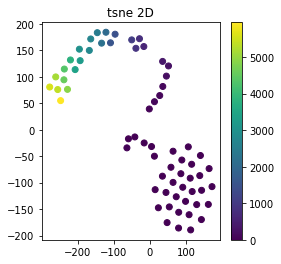

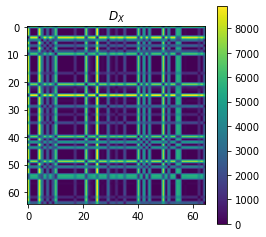

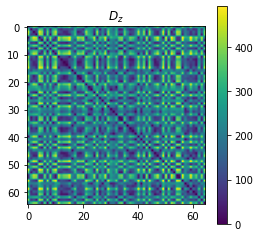

In [70]:
#tsne con mapeo
from sklearn.metrics import pairwise_distances

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

red = TSNE(n_components = 2,perplexity=10)
z = red.fit_transform(X_train)
ww=4
hh=4
plt.figure(figsize=(ww,hh))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.title('tsne 2D')
plt.show()
Dx = pairwise_distances(X_train,X_train)
plt.figure(figsize=(ww,hh))
plt.imshow(Dx)
plt.colorbar()
plt.title('$D_X$')
plt.show()
Dz = pairwise_distances(z,z)
plt.figure(figsize=(ww,hh))
plt.imshow(Dz)
plt.colorbar()
plt.title('$D_z$')
plt.show()
#ind = np.argsort(D,axis=0)





$$z_{new} = \sum_{n=1}^K w_{n,new} z_n; \quad z_n \in \Omega_{new}$$

$$\Omega_{new} \in \mathbb{R} ^{K \times P}$$ los K-vecinos mas cercanos de $x_{new}$ en  $X_{train}$

$$ \sum_{n=1}^K w_{n,new}=1$$, preservar noción de probabilidad, combianción lineal convexa.

$$w_{n,new} = \frac{\exp\left(-\frac{\|x_n - x_{new}\|^2_2}{2\sigma^2}\right)}{\sum_{n'=1}^K w_{n',new}}$$



In [90]:
xnew = X_test[0].reshape(1,-1)
ynew = y_test[0]
#znew = ?
dnew = pairwise_distances(xnew,X_train)
#knn-> buscar k instancias mas cercanas de xnew en X_train, y generar una combinacion de ellos para mapear a z 
sig = 10000
kk = 5
knew = np.exp(-dnew**2/(2*sig**2))
ind = np.argsort(knew)[::-1]
wnew = knew[0,ind[0,:kk]]
wnew /= sum(wnew)
wnew

znew = z[]

array([0.18841225, 0.19477493, 0.2007092 , 0.20602339, 0.21008022])

$$y_{new}=reg(red(scaler(x_{new})))$$

fit: entrenamiento, ajuste, aprende los parámetros utilizando los hyperparámetros fijados

Ej: red = PCA(n_components = 0.9); n_components hyperparameter

$$W^*=\arg \max_W W^\top X^\top X W\\
\quad \rm{s.t.} \quad W^\top W = I$$

$$ red(scaler(x_{new})) = scaler(x_{new})W$$ mapeo de PCA

mapeo - operacion: transformacion y predicción. Predicción es la última etapa en steps -> regresor

transformacion: scaler y rep (PCA)

Si mi modelo no tiene transformacion, no puedo utilizarlo en nuevos datos

Utilizar regresor: por vecindad -> KNN, K- nearest neighbors